# Classification evaluation with ROC and AUC
We will examine different models of NN, and error evaluation with *receiver operating characteristics* (ROC), and *area under the (ROC) curve* (AUC). Details as to understanding these ROC and AUC curves can be found on [Towards Data Science](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5).

In short; ROC is a probability curve, and AUC represents the degree of seperability, i.e. *how well* the model scrutinizes different classes. A greater AUC means the model is good at predicting classes as themselves.

The ROC is the curve resulting from plotting *true positve rate* (TPR) against *false positive rate* (FPR). We will explore this more later.

## Binary classification
Binary classification is trying to predict a *true* or *false* outcome (1 or 0). In such a scenario, the objective score of the model is the number of false positive predictions vs the number of false negatives. We pick the which 'error' is more relevant to our problem (the classic SPAM email evaluation).

Let us examine, for example, the WCBD database for breast tumors, and see if we can classify the tumors as malignant (M) or benign (B), such that a *true* output indicates an M classification.

In [1]:
import pandas as pd
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/wcbreast_wdbc.csv",
    na_values=['NA', '?']
)

df

,id,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In error analysis for classification networks, we often consider four types of errors. In our case, we may describe them as

|Type|Symb.|Description|
|-|-|-|
|False Positive|FP|NN identified M when patient actually B.|
|False Negative|FN|NN identified B when patient actually M.|
|True Positive|TP|NN identified M when patient M|
|True Negative|TN|NN identified B when patient B|

We can catagorize these by considering
- TP vs FP: a sensitivity test, type-1 error.
- TN vs FN: a specificity test, type-2 error.

When designing the NN, we also need to specify a cutoff; NN return a value between 0 and 1, interpreted as the confidence. We must define a point where we say the NN predicted 1. But this could be 0.5, 0.75, 0.9; this value is called the *threshold*, such that anything above the threshold is 1 and anything below is 0. We can balance between type-1 and type-2 errors by adjusting the threshold.

## Preparing data and helpers

Let us prepare the data, and apply a [Z-Score](https://www.statisticshowto.com/probability-and-statistics/z-score/) to all `x` columns, describing how far from the mean a given distribution is. The score is calculated for a given sample as
$$
z_i = \frac{x_i - \bar{x}}{\sigma}
$$
with $i$ denoting the element of the sample, $\bar{x}$ the mean, and $\sigma$ the standard deviation.

We can only meaningfully calculate a Z-score for numerical columns.

In [2]:
from scipy.stats import zscore

x_cols = df.columns.drop('diagnosis').drop('id')

for col in x_cols[:3]:
    df[col] = zscore(df[col]) # replace data with z-score

x = df[x_cols].values
y = df['diagnosis'].map({'M':1, 'B':0}).values # binary classification

Next, we define some helper functions for the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) and ROC curve:

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def show_confusion_matrix(cm, names, title="Confusion Matrix"):
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names)
    plt.yticks(tick_marks, names)
    
    plt.ylabel("Expected")
    plt.xlabel("Predicted")
    
def plot_roc(y, pred):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    
    fig = plt.figure()
    plt.plot(fpr, tpr, label=f"ROC: (area = {roc_auc:.4f})")
    
    plt.xlabel("FP Rate")
    plt.ylabel("TR Rate")
    plt.title("ROC")
    plt.legend()

## ROC curve example
Let us build a classificational NN for our data set. We will split the data into 75/25 ratio split train/test, and use a 3 hidden layer dense NN with a single output neuron.

We will implement an early stopping callback, monitoring the loss value.

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.25,
    random_state=414141
)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(
        100,
        input_dim=x.shape[1],
        activation='relu'
    ),
    tf.keras.layers.Dense(
        50,
        activation='relu'
    ),
    tf.keras.layers.Dense(
        25,
        activation='relu'
    ),
    tf.keras.layers.Dense(
        1,
        activation='sigmoid' # use sigmoid so between 0, 1
    )
])

model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics='accuracy' # metric to be evaluated by the model during epoch
)

monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3,
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 9,451
Trainable params: 9,451
Non-trainable params: 0
_________________________________________________________________


Now we fit our model:

In [5]:
model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    callbacks=[monitor],
    verbose=0,
    epochs=1000
)

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping


Now we can evaluate the ROC of our model:

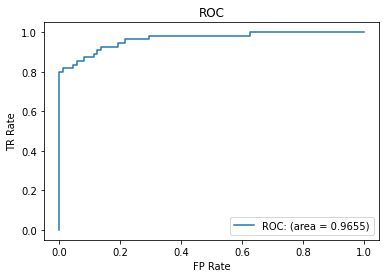

In [6]:
pred = model.predict(x_test)
plot_roc(y_test, pred)

We will also show the confusion matrix, but will use a basic normalization:

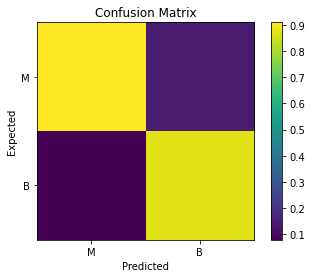

In [7]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(
    y_test, 
    np.around(pred).astype(np.uint8) # cast to 0, 1 with threshold 0.5
)

cm_norm = cm.astype('float') / cm.sum(axis=1)
show_confusion_matrix(cm_norm, ["M", "B"])

We see out model performs very well.